# Deep Dream

## Implementing Deep Dream in Keras

For implementing Deep Dream we will start from a convnet pre-trained on ImageNet. In Keras, we have many such convnets available: VGG16, VGG19, Xception, ResNet50... albeit the same process is doable with any of these, your convnet of choice will naturally affect your visualizations, since different convnet architectures result in different learned features. The convnet used in the original Deep Dream release was an Inception model, and in practice Inception is known to produce very nice-looking Deep Dreams, so we will use the InceptionV3 model that comes with Keras.

### Define the base model

We will use `InceptionV3` which is similar to the model originally used in DeepDream.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

base_model = tf.keras.applications.InceptionV3(
    include_top=False, 
    weights='imagenet'
)

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Next, we choose an image to dream-ify. Let's use an image of the Cagliari Calcio legend **Gigi Riva**.

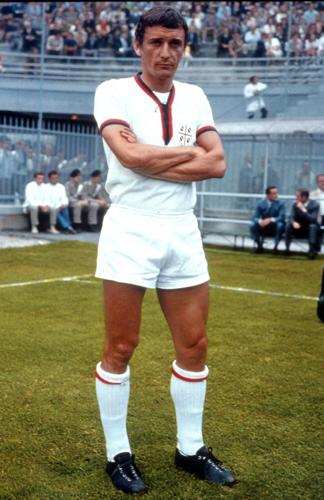

In [33]:
img_path = './resources/riva.jpg'

# Get an image and read it into a NumPy array.
def get_image(path, max_dim=None):
    img = PIL.Image.open(path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = get_image(img_path, max_dim=500)
show(original_img)

For _DeepDream_ , the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10' (see the model summary above). 

**Using different layers will result in different dream-like images**. 

Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). 

Feel free to experiment with the layers selected below, but keep in mind that **deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper**.

In [34]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

### Calculate loss

The loss is **the sum of the activations in the chosen layers**. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, we will maximize this loss via gradient ascent.

In [35]:
def calc_loss(img, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return  tf.reduce_sum(losses)

### Gradient ascent

Once we have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image.

Adding the gradients to the image enhances the patterns seen by the network. At each step, we will create an image that increasingly excites the activations of certain layers in the network.

The function that does this, below, is wrapped in a tf.function for performance. 

In [40]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to `img`
                # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [41]:
deepdream = DeepDream(dream_model)

### Main loop

In [42]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

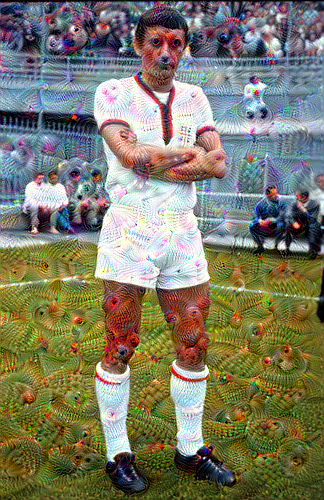

In [43]:
dream_img = run_deep_dream_simple(
    img=original_img, 
    steps=100, step_size=0.01
)

### Taking it up an octave

Pretty good, but there are a few issues with this first attempt:

- The output is noisy (this could be addressed with a `tf.image.total_variation` loss);
- The image is low resolution;
- The patterns appear like they're all happening at the same granularity;

One approach that addresses all these problems is **applying gradient ascent at different scales**. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this we can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.

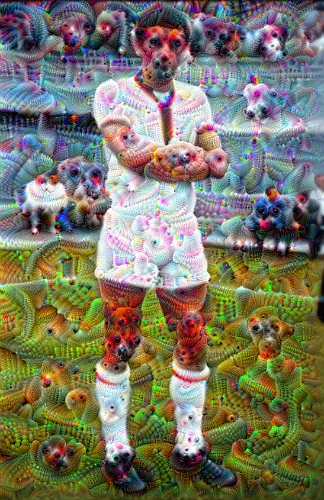

93.02515697479248

In [44]:
import time

start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end - start

### Save the result

In [57]:
from PIL import Image

im = Image.fromarray(np.uint8(img)).convert('RGB')
im.save('./results/dream_final.jpg')